# Link Prediction

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np
import torch.nn as nn
from torch_geometric.nn import GCNConv, to_hetero_with_bases
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE
from sklearn.metrics import accuracy_score
from torch import Tensor
import torch.nn.functional as F

## 1. data analysis

In [20]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")

In [3]:
# nx.draw_networkx(g) # Take to long time, not a good visualisation

In [21]:
print(len(g.nodes))
print(len(g.edges))

3363
13547


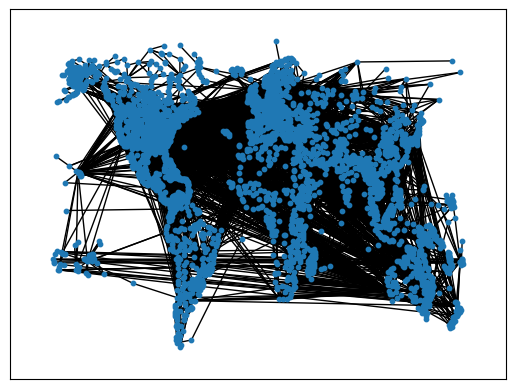

In [5]:
pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
nx.draw_networkx(g, pos=pos, node_size=10, with_labels=False)

With Gephi we have optain this graph:
![](./gephi_analyse/airports_coord_pop_graph.svg)

In [6]:
g.nodes(data=True)

NodeDataView({'0': {'lon': -145.50972222222222, 'lat': -17.35388888888889, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Anaa'}, '1': {'lon': -140.95, 'lat': -18.066666666666666, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Hao Island'}, '2': {'lon': -149.6, 'lat': -17.55, 'population': 26357, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Papeete'}, '3': {'lon': -135.0, 'lat': -23.033333333333335, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Gambier Island'}, '4': {'lon': -143.65725, 'lat': -16.584888888888887, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Makemo'}, '5': {'lon': 174.79166666666666, 'lat': -37.00805555555556, 'population': 417910, 'country': 'NEW_ZEALAND', 'city_name': 'Auckland'}, '6': {'lon': -139.03333333333333, 'lat': -9.8, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Atuona'}, '7': {'lon': -151.75, 'lat': -16.45, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 

In [31]:
g.graph = {}
data = from_networkx(g, group_node_attrs=["lon", "lat"])
data: Data = train_test_split_edges(data)

/home/ades/miniconda3/envs/pytorchgeo/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


après une  première analyse on se rend compte que grouper avec l'attribut population nous donne des "mauvais" résultat (auc: 0.5, accuracy: 0.5) ces valeurs

In [51]:
print(data)

Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 2], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354])


- x=[3363, 2] => pour chaque noeud, les coordonnées lat et lon
- val_pos_edge_index=[2, 677] => TODO comprendre la shape
- test_pos_edge_index=[2, 1354] => TODO comprendre la shape
- train_pos_edge_index=[2, 23032] => TODO comprendre la shape
- train_neg_adj_mask=[3363, 3363] => matrice d'adjacence, vrai si pas de lien, faux sinon
- val_neg_edge_index=[2, 677] => TODO comprendre la shape
- test_neg_edge_index=[2, 1354]) => TODO comprendre la shape


## 2. First Model

In [35]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels)
        self.conv_mu = GCNConv(2*out_channels, out_channels)
        self.conv_logstd = GCNConv(2*out_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [36]:
def train(model, eta: float, train_data):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=eta)
    optim.zero_grad()
    z = model.encode(train_data.x, train_data.train_pos_edge_index)
    # TODO je pense qu'on ne calcul pas comme il faut la loss, on devrais prendre en compte la neg matrice!
    loss = model.recon_loss(z, train_data.train_pos_edge_index) + (1 / train_data.x.size(0)) * model.kl_loss() 
    loss.backward()
    optim.step()
    return float(loss)

In [37]:
def calc_accu_val(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_pred = model.decode(z, data.val_pos_edge_index)
    neg_pred = model.decode(z, data.val_neg_edge_index)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))], dim=0)

    pred_binary = (preds > 0.5).float()

    accuracy = accuracy_score(labels.cpu(), pred_binary.cpu())

    return accuracy

def calc_accu_test(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_score = model.decode(z, data.test_pos_edge_index)
    neg_score = model.decode(z, data.test_neg_edge_index)

    y_true = torch.cat([torch.ones(data.test_pos_edge_index.size(1)), 
                         torch.zeros(data.test_neg_edge_index.size(1))])

    scores = torch.cat([pos_score, neg_score])

    y_pred = (scores > 0.5).float()

    accuracy = accuracy_score(y_true.cpu(), y_pred.cpu())

    return accuracy

In [38]:
def hyperparameter_tuning(data, num_epochs_values, lr_values, outputs_values):
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bout = 0
    bmodel = None
    i = 0
    for lr in lr_values:
        for num_epoch in num_epochs_values:
            for output in outputs_values:
                print(f'Trial {i} : Epoch {num_epoch}, LR: {lr}, NB output: {output} \n')
                for epoch in range(num_epoch):
                    model = Encoder(data.num_features, output)
                    model = VGAE(model)
                    loss = train(model, lr, data) 
                    if (loss < min_loss):
                        min_loss = loss
                        bepoch = epoch
                        blr = lr
                        bout = output
                        bmodel = model
                        print(f'Epoch {bepoch}, LR: {blr}, NB output: {bout}, Loss: {min_loss:.4f}')
                i += 1
    return bmodel, min_loss, bepoch, blr, bout

bmodel, min_loss, bepoch, blr, bout = hyperparameter_tuning(data, [100, 1000], [0.01, 0.001, 0.0001], [4, 32, 64])

Trial 0 : Epoch 0, LR: 0, NB output: 0 

Epoch 0, LR: 0.01, NB output: 4, Loss: 113125.2656
Epoch 1, LR: 0.01, NB output: 4, Loss: 55991.7812
Epoch 4, LR: 0.01, NB output: 4, Loss: 46724.5195
Epoch 7, LR: 0.01, NB output: 4, Loss: 23218.2773
Epoch 18, LR: 0.01, NB output: 4, Loss: 30.2000
Trial 1 : Epoch 18, LR: 0.01, NB output: 4 

Trial 2 : Epoch 18, LR: 0.01, NB output: 4 

Trial 3 : Epoch 18, LR: 0.01, NB output: 4 

Epoch 32, LR: 0.01, NB output: 4, Loss: 20.2106
Trial 4 : Epoch 32, LR: 0.01, NB output: 4 

Trial 5 : Epoch 32, LR: 0.01, NB output: 4 

Trial 6 : Epoch 32, LR: 0.01, NB output: 4 

Trial 7 : Epoch 32, LR: 0.01, NB output: 4 

Trial 8 : Epoch 32, LR: 0.01, NB output: 4 

Trial 9 : Epoch 32, LR: 0.01, NB output: 4 

Trial 10 : Epoch 32, LR: 0.01, NB output: 4 

Trial 11 : Epoch 32, LR: 0.01, NB output: 4 

Trial 12 : Epoch 32, LR: 0.01, NB output: 4 

Trial 13 : Epoch 32, LR: 0.01, NB output: 4 

Trial 14 : Epoch 32, LR: 0.01, NB output: 4 

Trial 15 : Epoch 32, LR: 0.

In [41]:
calc_accu_val(bmodel, data)

0.7163958641063516

In [42]:
calc_accu_test(bmodel, data)

0.7163958641063516

number of nodes: 3363
number of edges: 3012325


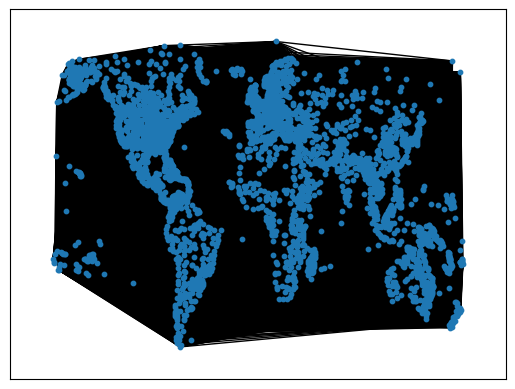

In [43]:
def visualise_output_prediction(bmodel, data, g):
    z = bmodel.encode(data.x, data.train_pos_edge_index)
    Ahat = torch.sigmoid(z @ z.T)
    Ahat = Ahat-torch.eye(len(Ahat), len(Ahat))
    rows, cols = np.where(Ahat == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = g.copy()
    gr.remove_edges_from(list(gr.edges()))
    for u, v in edges:
        if str(u) in gr.nodes and str(v) in gr.nodes:
            gr.add_edge(str(u), str(v))
    print("number of nodes:", len(gr.nodes))
    print("number of edges:", len(gr.edges))
    pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
    nx.draw_networkx(gr, pos=pos, node_size=10, with_labels=False)
visualise_output_prediction(bmodel, data, g)

In [52]:
bmodel.eval()
z = bmodel.encode(data.x, data.train_pos_edge_index)
bmodel.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

(np.float64(0.7212335462080733), np.float64(0.6430072252809136))

## 3. Second Model GNN

In [21]:
class GNN(nn.Module):
    def __init__(self, input_num: int, hidden_num: int, output_num: int):
        super(GNN, self).__init__()
        self.hidelayer1 = nn.Linear(input_num, hidden_num)
        self.output = nn.Linear(hidden_num, output_num)

    def encode(self, x, edge_index):
        x = self.hidelayer1(x)
        x = F.relu(x)
        return self.output(x)

    def decode(self, z, edge_index):
        node_embeddings_1 = z[edge_index[0]] 
        node_embeddings_2 = z[edge_index[1]] 

        link_scores = torch.sum(node_embeddings_1 * node_embeddings_2, dim=-1)
        return torch.sigmoid(link_scores) 

    def recon_loss(self, z, pos_edge_index):
        pos_pred = self.decode(z, pos_edge_index)
        pos_loss = F.binary_cross_entropy(pos_pred, torch.ones(pos_pred.size(0))) 
        return pos_loss

    def kl_loss(self):
        return torch.tensor(0.0)

    def forward(self, x):
        return self.encode(x, None)

In [43]:
def train_GNN(model, eta: float, train_data):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=eta)
    optim.zero_grad()
    z = model.encode(train_data.x, train_data.train_pos_edge_index)
    recon_loss = model.recon_loss(z, train_data.train_pos_edge_index)
    kl_loss = (1 / train_data.x.size(0)) * model.kl_loss()    
    loss = recon_loss + kl_loss
    loss.backward()
    optim.step()
    return float(loss)

In [44]:
def calc_accu_val(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_pred = model.decode(z, data.val_pos_edge_index)
    neg_pred = model.decode(z, data.val_neg_edge_index)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))], dim=0)

    pred_binary = (preds > 0.5).float()

    accuracy = accuracy_score(labels.cpu(), pred_binary.cpu())

    return accuracy

from sklearn.metrics import accuracy_score

def calc_accu_test(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_score = model.decode(z, data.test_pos_edge_index)
    neg_score = model.decode(z, data.test_neg_edge_index)

    y_true = torch.cat([torch.ones(data.test_pos_edge_index.size(1)), 
                        torch.zeros(data.test_neg_edge_index.size(1))])

    scores = torch.cat([pos_score, neg_score])

    y_pred = (scores > 0.5).float()

    accuracy = accuracy_score(y_true.cpu(), y_pred.cpu())

    return accuracy

In [49]:
def hyperparameter_tuning_gnn(data, num_epochs_values, lr_values, hidden_values, outputs_values):
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bhidden = 0
    bout = 0
    bmodel = None
    i = 0
    for lr in lr_values:
        for num_epoch in num_epochs_values:
            for hidden in hidden_values:
                for output in outputs_values:
                    for epoch in range(num_epoch):
                        print(f'Trial {i} : Epoch {epoch}, LR: {lr}, NB hidden : {hidden}, NB output: {output} \n')
                        model = GNN(data.num_features, hidden, output)
                        loss = train_GNN(model, lr, data) 
                        if (loss < min_loss):
                            min_loss = loss
                            bepoch = epoch
                            blr = lr
                            bhidden = hidden
                            bout = output
                            bmodel = model
                            print(f'Epoch {bepoch}, LR: {blr},  NB hidden : {bhidden}, NB output: {bout}, Loss: {min_loss:.4f}')
                    i += 1
    return bmodel, min_loss, bepoch, blr, bhidden, bout

bmodel, min_loss, bepoch, blr, bhidden, bout = hyperparameter_tuning_gnn(data, [100, 1000], [0.01, 0.001, 0.0001], [124, 248, 516], [4, 32, 64])

Trial 0 : Epoch 0, LR: 0.01, NB hidden : 124, NB output: 4 

Epoch 0, LR: 0.01,  NB hidden : 124, NB output: 4, Loss: 0.0000
Trial 0 : Epoch 1, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 2, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 3, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 4, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 5, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 6, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 7, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 8, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 9, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 10, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 11, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 12, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 13, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 14, LR: 0.01, NB hidden : 124, NB output: 4 

Trial 0 : Epoch 

In [50]:
min_loss, bepoch, blr, bhidden, bout

(0.0, 0, 0.01, 124, 4)

In [57]:
calc_accu_val(bmodel, data)

0.5042451088962717

In [53]:
calc_accu_test(bmodel, data)

0.5039678877918243